# Libraries

In [4]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import sklearn as sklearn
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn import model_selection

# parameters
input_channels = 5 # open, high, low, close, volume
activation_function = nn.LeakyReLU()
learning_rate = 0.001
epochs = 1000
loss_function = nn.MSELoss()
window_size = 15 # 15 day window
scaler = StandardScaler()

# loading in the dataset

In [5]:
df = pd.read_csv("data.csv")
df = df[df["Company"] == "SBUX"] # select stock option

open_data = list()
close_data = list()
high_data = list()
low_data = list()
volume_data = list()

# fixing dataset format

start_index = df.index[0]

for i in range(len(df)):
  i += start_index
  open_data.append(float(df["Open"][i][1:]))
  close_data.append(float(df["Close/Last"][i][1:]))
  high_data.append(float(df["High"][i][1:]))
  low_data.append(float(df.Low[i][1:]))
  volume_data.append(float(df.Volume[i]))

open_data.reverse()
high_data.reverse()
low_data.reverse()
close_data.reverse()
volume_data.reverse()

In [6]:
data = []

# first we fit our scaler to our mean and standard deviation
scaled_data = scaler.fit_transform(
  torch.tensor([open_data, high_data, low_data, close_data, volume_data]).T
)

# this gets the closing price to predict but we don't want the first windows input data 
target = torch.tensor(scaled_data[window_size:, 3:4], dtype=torch.float)

# this selects our windows and adds them to one list
for i in range(len(open_data) - window_size):
  data.append([
    open_data[i:i + window_size],
    high_data[i:i + window_size], 
    low_data[i:i + window_size], 
    close_data[i:i + window_size], 
    volume_data[i:i + window_size]])

# in order to scale our data we have to swap the rows and columns around
data = torch.tensor(data).permute([0, 2, 1])

# this scales each window to our mean and standard deviation
for i in range(len(data)):
  data[i] = torch.tensor(scaler.transform(data[i]))

# change it back
data = data.permute([0, 2, 1])
  
train_x, test_x, train_y, test_y = sklearn.model_selection.train_test_split(data, target, random_state=7, shuffle=False)


# Building the model
The network is set up to output a single value prediction. Probably the closing price for some future date.

In [7]:
class Net(nn.Module): # the nn.Module is set up as the parent class for the Net Class
    def __init__(self):
        super(Net, self).__init__() # This calls the init method of the nn.Module parent class to ensure that its been initialized

        self.model = nn.Sequential(
            nn.Conv1d(in_channels=input_channels, out_channels=64, kernel_size=2, stride=1),
            activation_function,
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=2, stride=1),
            activation_function,
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(in_features=384, out_features=128),
            activation_function,
            nn.Linear(128, 64),
            activation_function,
            nn.Linear(64, 1),
        )

    def forward(self, x):

        return self.model(x)


net = Net()

# Training the model

In [ ]:
def train(model: nn.Module, train_x, train_y, epochs, learning_rate):
  optimizer = optim.Adam(net.parameters(), lr=learning_rate)

  for epoch in range(epochs):
    y_hat = net(train_x)
    loss = loss_function(y_hat, train_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 50 == 0: # print out the loss as the model is training
      print(f"Epoch: {epoch}, Loss: {loss.item():.10f}")

train(net, train_x, train_y, epochs, learning_rate)


Epoch: 0, Loss: 0.6436104178
Epoch: 50, Loss: 0.0082096225
Epoch: 100, Loss: 0.0062379660
Epoch: 150, Loss: 0.0048004715
Epoch: 200, Loss: 0.0038142004
Epoch: 250, Loss: 0.0031024250
Epoch: 300, Loss: 0.0025710338
Epoch: 350, Loss: 0.0022161235
Epoch: 400, Loss: 0.0019759408
Epoch: 450, Loss: 0.0017962621
Epoch: 500, Loss: 0.0016100178
Epoch: 550, Loss: 0.0014451573
Epoch: 600, Loss: 0.0016081049
Epoch: 650, Loss: 0.0013502992
Epoch: 700, Loss: 0.0011571635
Epoch: 750, Loss: 0.0011360433
Epoch: 800, Loss: 0.0012598772
Epoch: 850, Loss: 0.0008941094
Epoch: 900, Loss: 0.0008148045


# Running the model

In [ ]:
y_hat = net(test_x)
print(loss_function(y_hat, test_y))

price_prediction = y_hat.tolist()
# Convert price_prediction to numpy array and inverse transform only the closing price column

# Convert to numpy array and ensure shape is (n_samples, 1)
price_prediction_np = np.array(price_prediction).reshape(-1, 1)

# Create a placeholder array with the same number of features as original data
# Fill with zeros, then set the close price column (index 3) to the predicted values
full_pred = np.zeros((price_prediction_np.shape[0], scaled_data.shape[1]))
full_pred[:, 3] = price_prediction_np[:, 0]

# Inverse transform
inv_price_prediction = scaler.inverse_transform(full_pred)[:, 3]
# Inverse transform the actual test_y values
test_y_np = test_y.numpy().reshape(-1, 1)
full_actual = np.zeros((test_y_np.shape[0], scaled_data.shape[1]))
full_actual[:, 3] = test_y_np[:, 0]
inv_actual_price = scaler.inverse_transform(full_actual)[:, 3]

# Create a DataFrame to compare predictions and actual prices
comparison_df = pd.DataFrame({
    'Predicted_Close': inv_price_prediction,
    'Actual_Close': inv_actual_price
})
pd.set_option('display.max_rows', None)
print(comparison_df)

tensor(0.0194, grad_fn=<MseLossBackward0>)
     Predicted_Close  Actual_Close
0         102.640895    105.459998
1         103.055830    104.580002
2         102.072006    103.910004
3         104.192727    103.449996
4         103.660190    104.690004
5         103.586708     97.870003
6          97.693368     98.150001
7          96.241856     96.809997
8          96.361376     98.580001
9          90.921060    101.650001
10        101.049676    101.019997
11        100.486578    103.640000
12        102.485048    106.480005
13        103.915027    106.260003
14        105.342140    106.220001
15        103.961249    105.870003
16        105.064998    105.860001
17        111.669688    105.300002
18        106.903847    106.150001
19        110.784525    104.440003
20        108.734367    104.970002
21        104.315270    103.370002
22        105.356459    101.809997
23        104.134599    101.370003
24        101.714172    104.379998
25        102.859464    103.470001
26        10

# saving the model

In [ ]:
# torch.save(net, "file_name.pt")

# Graphing

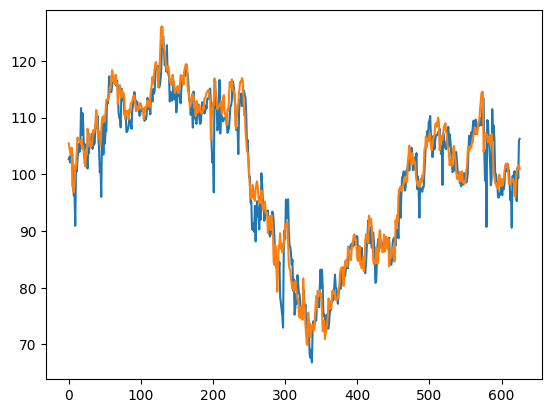

In [ ]:
plt.plot(inv_price_prediction)
plt.plot(inv_actual_price)
plt.show()
